<a href="https://colab.research.google.com/github/clizarraga-UAD7/Notebooks/blob/main/LowCodeTimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Low-code Time Series Analysis.

There are several low-code Python libraries available for Time Series Analysis. Here are some of the most popular ones:

* [PyCaret Time Series Analysis](https://pycaret.gitbook.io/docs/learn-pycaret/official-blog/time-series-101-for-beginners): This is a low-code library for time series forecasting and anomaly detection. It provides a simple and intuitive interface for working with time-series data, and includes several built-in models for forecasting and anomaly detection.

* [Darts Time Series Analysis](https://unit8co.github.io/darts/). Darts is a Python library for user-friendly forecasting and anomaly detection on time series. It contains a variety of models, from classics such as ARIMA to deep neural networks.



## PyCaret

In [14]:
# install pycaret in Google Colab including pre-releases
!pip install --pre pycaret --quiet


In [1]:
# Load required libraries
import numpy as np
import pandas as pd

from datetime import date

import pycaret
# import the regression module
from pycaret.regression import *
from pycaret.time_series import *

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px


In [12]:
# Read the monthly means CO2 levels dataset from Mauna Loa Observatory
# URL= https://gml.noaa.gov/ccgg/trends/data.html 
co2data = "https://raw.githubusercontent.com/clizarraga-UAD7/Datasets/main/MaunaLoaCO2/co2_mm_mlo.csv"
# The file has Metadata first 56 lines
# The column names are in line 57
df_dist = pd.read_csv(co2data, header=0 , skiprows=56)

# AIr passengers data
#passengers = "https://raw.githubusercontent.com/clizarraga-UAD7/Datasets/main/AirPassengers.csv"
#df_dist = pd.read_csv(passengers)
#df_dist['Month'] = pd.to_datetime(df_dist['Month'])
#df_dist = df_dist.rename(columns={'#Passengers': 'Passengers', 'Month':'Date'})

# Print the dataframe head.
df_dist.head()


,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


In [13]:
df_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            780 non-null    int64  
 1   month           780 non-null    int64  
 2   decimal date    780 non-null    float64
 3   average         780 non-null    float64
 4   deseasonalized  780 non-null    float64
 5   ndays           780 non-null    int64  
 6   sdev            780 non-null    float64
 7   unc             780 non-null    float64
dtypes: float64(5), int64(3)
memory usage: 48.9 KB


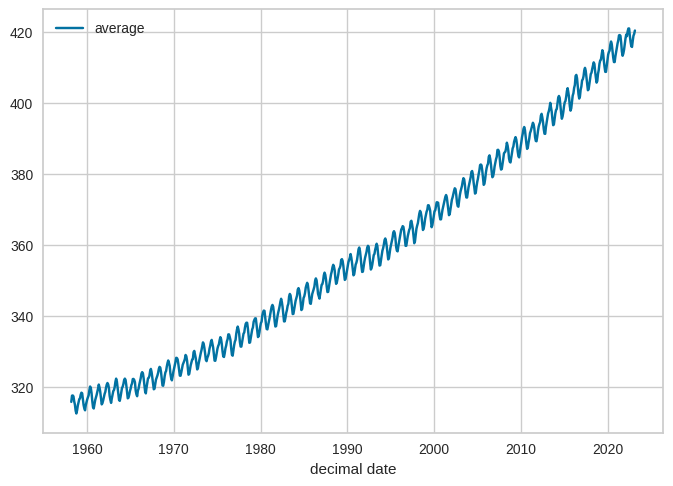

In [14]:
# Plot the dataset
df_dist.plot.line(x='decimal date', y='average');

In [15]:
# Prepare data for Machine Learning Model
df = df_dist.copy()

# Create Month and Year columns
#df['Month']=df['Date'].dt.month
#df['Year'] = df['Date'].dt.year 

# create a sequence of numbers
df['series'] = np.arange(1,len(df)+1)

# drop unnecessary columns and re-arrange

dfML = df[['series', 'year', 'month', 'average']] 

# check the head of the dataset
dfML.head()


,series,year,month,average
0,1,1958,3,315.70
1,2,1958,4,317.45
2,3,1958,5,317.51
3,4,1958,6,317.24
4,5,1958,7,315.86


In [16]:
dfML.tail()


,series,year,month,average
775,776,2022,10,415.78
776,777,2022,11,417.51
777,778,2022,12,418.95
778,779,2023,1,419.47
779,780,2023,2,420.41


In [18]:
# Select from year 1990
dfML = dfML[dfML['year'] >= 1990] 

# split data into train-test set, at year=2022
train = dfML[dfML['year'] < 2022]
test = dfML[dfML['year'] >= 2022]

# check shape
train.shape, test.shape


((384, 4), (14, 4))

In [19]:
from pycaret.regression import *

# initialize setup
s = setup(data = train, test_data = test, target = 'average', fold_strategy = 'timeseries', numeric_features = ['year', 'series'], fold = 3, 
          transform_target = True, session_id = 123)


,Description,Value
0,Session id,123
1,Target,average
2,Target type,Regression
3,Original data shape,"(398, 4)"
4,Transformed data shape,"(398, 4)"
5,Transformed train set shape,"(384, 4)"
6,Transformed test set shape,"(14, 4)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


In [20]:
# Train and evaluate models
best = compare_models(sort = 'MAE')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,3.4280,17.0827,3.8469,0.3359,0.0099,0.0088,0.1867
lr,Linear Regression,3.4951,17.6329,3.9179,0.3142,0.0101,0.0090,1.0833
br,Bayesian Ridge,3.4951,17.6329,3.9179,0.3142,0.0101,0.0090,0.1400
ridge,Ridge Regression,3.4953,17.6346,3.9182,0.3142,0.0101,0.0090,0.1500
lar,Least Angle Regression,3.6725,20.3847,4.1361,0.2071,0.0106,0.0094,0.1267
omp,Orthogonal Matching Pursuit,3.9770,22.0969,4.4723,0.1389,0.0115,0.0102,0.1400
catboost,CatBoost Regressor,10.3915,134.7321,11.5454,-3.8318,0.0297,0.0265,1.0100
rf,Random Forest Regressor,11.0040,151.4873,12.1596,-4.4166,0.0313,0.0280,0.3700
ada,AdaBoost Regressor,11.2678,157.8274,12.4276,-4.6537,0.0320,0.0287,0.1533
gbr,Gradient Boosting Regressor,11.3224,161.1963,12.4432,-4.8312,0.0321,0.0288,0.1633


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [21]:
# The best model based on MAE
prediction_holdout = predict_model(best);


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,417.7656,174530.8881,417.7689,-31957859180655360.0000,5.4434,512.8237


In [22]:
# generate predictions on the original dataset

predictions = predict_model(best, data=dfML)

# add a date column in the dataset
predictions['date'] = pd.date_range(start='1990-01-01', end = '2023-02-01', freq = 'MS')

# line plot
fig = px.line(predictions, x='date', y=['average', 'prediction_label'], template = 'plotly_white')

# add a vertical rectange for test-set separation
fig.add_vrect(x0='2022-01-01', x1='2023-02-01', fillcolor='grey', opacity=0.25, line_width=0)
fig.show()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,382.5465,146728.3691,383.0514,-122990484849574.8906,5.3547,469.6235


In [23]:
predictions.head()


,series,year,month,average,prediction_label,date
382,383,1990,1,353.859985,353.446605,1990-01-01
383,384,1990,2,355.100006,353.244758,1990-02-01
384,385,1990,3,355.750000,353.043167,1990-03-01
385,386,1990,4,356.380005,352.841831,1990-04-01
386,387,1990,5,357.380005,352.640750,1990-05-01


In [24]:
predictions.tail()

,series,year,month,average,prediction_label,date
775,776,2022,10,415.779999,416.984503,2022-10-01
776,777,2022,11,417.510010,416.693150,2022-11-01
777,778,2022,12,418.950012,416.402249,2022-12-01
778,779,2023,1,419.470001,422.147857,2023-01-01
779,780,2023,2,420.410004,421.848432,2023-02-01


In [25]:
# define array size variable
lenp = len(predictions) +1
lenp


399

In [31]:
final_best = finalize_model(best)

In [29]:
# series number starts at 383
series_shift=382 
future_dates = pd.date_range(start = '2023-03-01', end = '2026-01-01', freq = 'MS')
lenfd = len(future_dates)

future_df = pd.DataFrame()

future_df['month'] = [i.month for i in future_dates]
future_df['year'] = [i.year for i in future_dates]    
future_df['series'] = np.arange(lenp+series_shift, (lenp+series_shift+lenfd))
future_df.head()


,month,year,series
0,3,2023,781
1,4,2023,782
2,5,2023,783
3,6,2023,784
4,7,2023,785


In [32]:
predictions_future = predict_model(final_best, data=future_df)
predictions_future.head()


,month,year,series,prediction_label
0,3,2023,781,421.847325
1,4,2023,782,421.550843
2,5,2023,783,421.254883
3,6,2023,784,420.959443
4,7,2023,785,420.664522


In [33]:
predictions_future.tail()

,month,year,series,prediction_label
30,9,2025,811,425.309119
31,10,2025,812,425.006503
32,11,2025,813,424.704426
33,12,2025,814,424.402887
34,1,2026,815,430.466899


In [35]:
# Plot actual data and future predictions 

concat_df = pd.concat([dfML, predictions_future], axis=0)
concat_df_i = pd.date_range(start='1990-01-01', end = '2026-01-01', freq = 'MS')
concat_df.set_index(concat_df_i, inplace=True)

fig = px.line(concat_df, x=concat_df.index, y=['average', 'prediction_label'], template = 'plotly_white')
fig.show()


## Darts

In [67]:
# Install the Darts library
!pip install --pre darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 592.0/592.0 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372.4 KB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.9/242.9 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.8/187.8 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 KB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) 

In [71]:
%matplotlib inline
## Importing Libraries
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    RegressionEnsembleModel,
    RegressionModel,
    Theta,
    FFT
)

from darts.metrics import mape, mase
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.datasets import AirPassengersDataset

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


<Axes: xlabel='decimal date'>

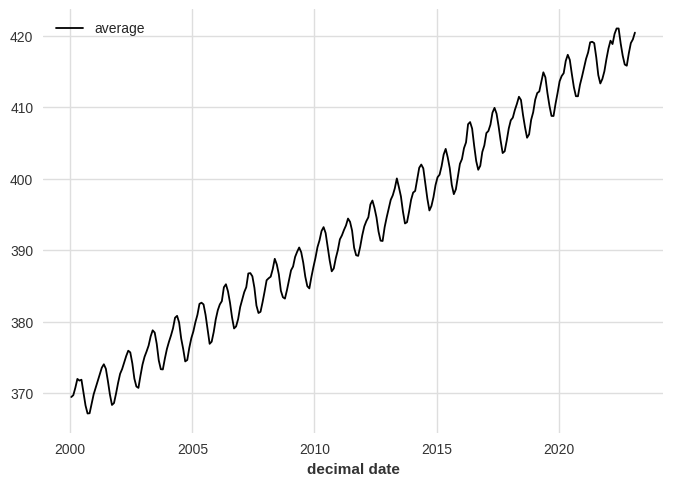

In [72]:
# Preview CO2 concentrations
df2k.plot.line(x='decimal date', y='average')

In [73]:
df2k['date'] = pd.to_datetime(df2k[['year', 'month']].assign(DAY=1))

df2k.head()


,year,month,decimal date,average,deseasonalized,ndays,sdev,unc,ma12,series,date
502,2000,1,2000.0417,369.45,369.24,26,0.48,0.18,368.631667,1,2000-01-01
503,2000,2,2000.1250,369.71,368.99,19,0.48,0.21,368.667500,2,2000-02-01
504,2000,3,2000.2083,370.75,369.24,30,0.47,0.16,368.743333,3,2000-03-01
505,2000,4,2000.2917,371.98,369.44,27,0.58,0.21,368.812500,4,2000-04-01
506,2000,5,2000.3750,371.75,368.87,28,0.53,0.19,368.865000,5,2000-05-01


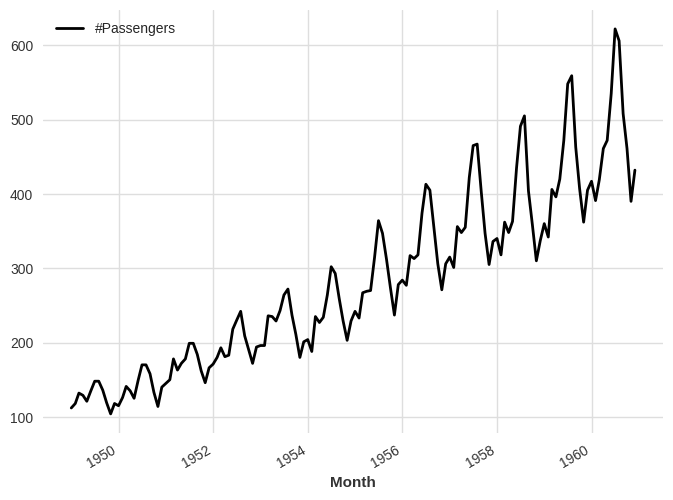

In [75]:
## Load the pre-loaded Dataset
series = AirPassengersDataset().load()
series.plot()

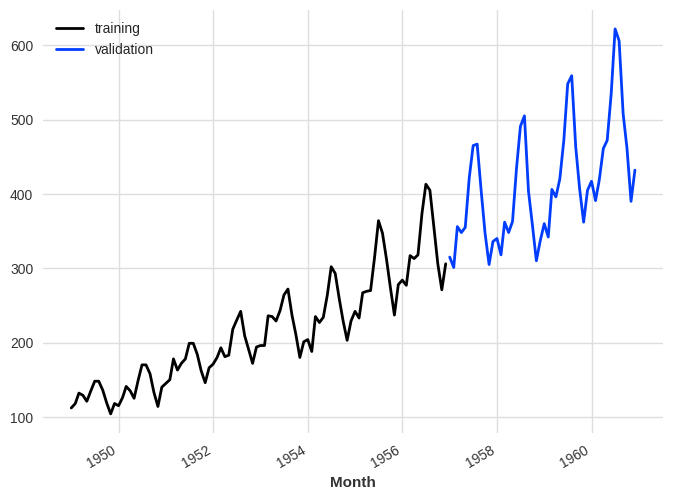

In [80]:
## Split train and test data
train, val = series.split_before(pd.Timestamp('19570101'))
train.plot(label='training')
val.plot(label='validation')
plt.legend();


In [88]:
# Fitting multiple models and checking the MAPE (Mean Absolute Percentage Error). The higher the better.
def eval_model(model):
  model.fit(train)
  forecast = model.predict(len(val))
  print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))


In [89]:
# Evaluate a set of models
eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 obtains MAPE: 5.03%
model Prophet obtains MAPE: 9.43%
model Auto-ARIMA obtains MAPE: 18.83%
model Theta(2) obtains MAPE: 10.22%


NameError: ignored

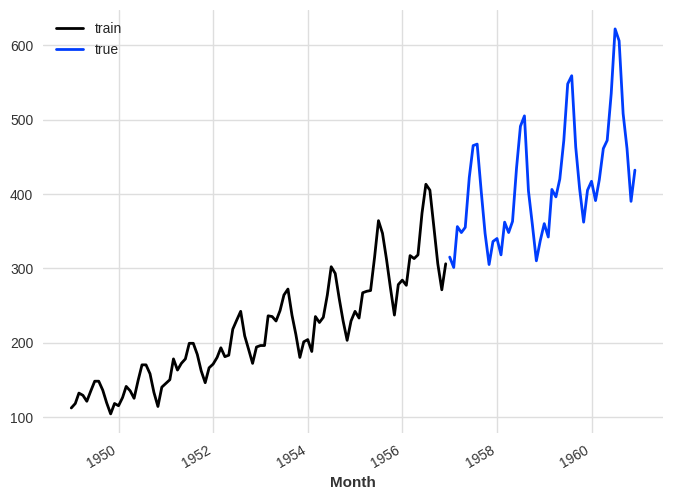

In [90]:
## Visualizing theta foreacsting result
train.plot(label='train')
val.plot(label='true')
forecast.plot(label='prediction')
plt.legend();


In [85]:
# Tuning the theta parameter to see if MAPE reduces
##Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float('inf')
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta


In [86]:
## Fitting and predicting again usinh best theta value
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print('The MAPE is: {:.2f}, with theta = {}.'.format(mape(val, pred_best_theta), best_theta))


The MAPE is: 4.45, with theta = -3.1020408163265305.


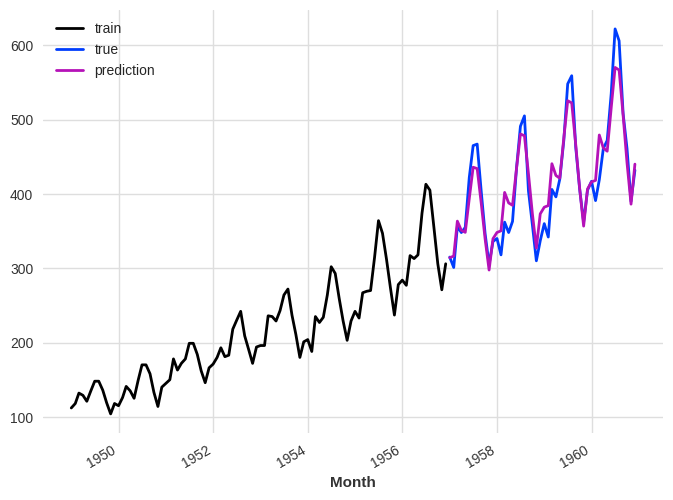

In [87]:
# Visualize 
train.plot(label='train')
val.plot(label='true')
pred_best_theta.plot(label='prediction')
plt.legend();